# Classify apple and orange images

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import datetime

# 1. create a dataset
## 1.0 download the training and validation dataset and transform them to tensor.


In [132]:
from torchvision import datasets
from torchvision import transforms
datapath = './data'
#download the training data set 
CIFAR100=datasets.CIFAR100(root=datapath,train=True,download=True)

100.0%


Extracting ./data\cifar-100-python.tar.gz to ./data


In [133]:
img,_=CIFAR100[0]
type(img)

PIL.Image.Image

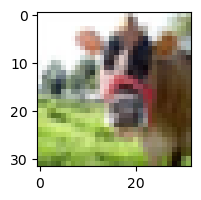

In [134]:
fig=plt.figure(figsize=(2,2))
plt.imshow(img)
plt.show()

In [135]:
#download the training data and normalize the PIL.Image as tensor
CIFAR100_t=datasets.CIFAR100(root=datapath,train=True,download=True,transform=transforms.ToTensor())

Files already downloaded and verified


In [136]:
CIFAR100_t

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [137]:
img1,label1=CIFAR100_t[0]

In [138]:
type(img1),img1.shape, img1.dtype, label1

(torch.Tensor, torch.Size([3, 32, 32]), torch.float32, 19)

In [139]:
#transforms.ToTensor() scale the img1 into range [0,1]
img1.min(), img1.max()

(tensor(0.0039), tensor(1.))

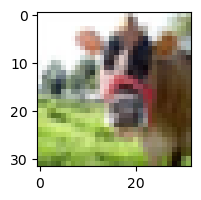

In [140]:
#permute the tensor from C*H*W to H*W*C to match matplotlib
fig=plt.figure(figsize=(2,2))
plt.imshow(img1.permute(1,2,0))
plt.show()

## 1.1 compute the mean and std of each channel of all the images; use them to normalize each channel

In [141]:
#stack all the images together at dimension 3
img_all = torch.stack([img for img, label in CIFAR100_t], dim=3)
img_all.shape

torch.Size([3, 32, 32, 50000])

In [142]:
#compute the mean and std for each channel
mean=img_all.view(3,-1).mean(dim=1)
std=img_all.view(3,-1).std(dim=1)

In [143]:
#normalize each channel to have zero mean and 1 std
#create the training and validation data set
CIFAR100_t_u=datasets.CIFAR100(root=datapath,train=True,download=True,transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean,std=std)]))

CIFAR100_t_u_val=datasets.CIFAR100(root=datapath,train=False,download=True,transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=mean,std=std)]))

Files already downloaded and verified
Files already downloaded and verified


In [144]:
img,label=CIFAR100_t_u[0]
img.min(), img.max(), label

(tensor(-1.7903), tensor(2.0246), 19)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.790285..2.0245562].


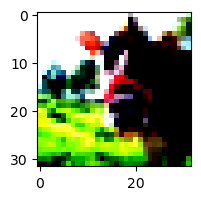

In [145]:
#plot the normalized image
fig=plt.figure(figsize=(2,2))
plt.imshow(img.permute(1,2,0))
plt.show()

In [146]:
CIFAR100_t_u[0][1]

19

In [147]:
CIFAR100_t_u[99][1]

93

In [148]:
CIFAR100_t_u_val

Dataset CIFAR100
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=tensor([0.5071, 0.4865, 0.4409]), std=tensor([0.2673, 0.2564, 0.2762]))
           )

In [149]:
# subset a dataset
# 0 label is for apple, 53 label is for orange
#map the label from 0,53 to 0, 1
label_map={0:0,53:1}
data_train = [(img, label_map[label]) for img, label in CIFAR100_t_u if label in [0,53]]
data_val = [(img, label_map[label]) for img, label in CIFAR100_t_u_val if label in [0,53]]

In [150]:
len(data_train), len(data_val)

(1000, 200)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.596658..2.0245562].


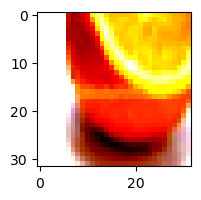

In [151]:
fig=plt.figure(figsize=(2,2))
img1=data_train[2][0]
label1=data_train[2][1]
plt.imshow(img1.permute(1,2,0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.596658..2.002239].


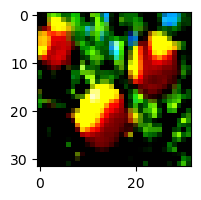

In [152]:
fig=plt.figure(figsize=(2,2))
img2=data_train[1][0]
label2=data_train[1][1]
plt.imshow(img2.permute(1,2,0))
plt.show()

In [153]:
len(data_train),len(data_val)

(1000, 200)

# 2. create a fully connected neural network for classification
We first built a simple fully connected neural network to classify apple and orange and train it using stochatic gradient descent. The learning rate, batch size are the hyperparameters we need to adjust.

Since simple fully connected neural network only accept 1 dimensional input and the images are 3 dimensional, we need to convert the image into 1 dimension.

## 2.0 build and train a fully connected model

In [154]:
#compute the input size
img1.view(-1).shape

torch.Size([3072])

In [218]:
#create a training dataloader with batch size 64
train_loader= torch.utils.data.DataLoader(data_train,batch_size=64,shuffle=True)
#create a linear model with 2 linear layers
model_connected =nn.Sequential(
    nn.Linear(3072,512),
    #number of params=3072*512+512=157,3376
    nn.Tanh(),
    nn.Linear(512,2),
    #number of params=512*2+2=1026
    #total params=157,4402
    nn.LogSoftmax(dim=1))

#nn.LogSoftmax + nn.NLLLoss = nn.CrossEntropyLoss

In [219]:
# check how many trainable params our model has
numel_list_train = [p.numel() for p in model_connected.parameters() if p.requires_grad==True]
numel_list_all = [p.numel() for p in model_connected.parameters()]
params_train_sum=sum(numel_list_train)
params_sum=sum(numel_list_all)
print(numel_list_train, params_train_sum, numel_list_all, params_sum)

[1572864, 512, 1024, 2] 1574402 [1572864, 512, 1024, 2] 1574402


We can see that our fully connected neural network has 1.5 million parameters, which is a huge number, indicating the possibility of overfitting. In addition, the number goes higher as we have more pixels. This means our neural network won't scale very well with the number of pixels.

In [220]:
#start training, update the parameters for each batch
loss_fn=nn.NLLLoss()
learning_rate=1e-2
optimizer=optim.SGD(model_connected.parameters(),lr=learning_rate)
n_epochs=200
for epoch in range(n_epochs+1):
    for images, labels in train_loader:
        batch_size=images.shape[0]
        #reshape the images into batch_size*others for linear model
        outs=model_linear(images.view(batch_size,-1))
        #default reduction=mean is computing the averaging loss across the whole batch
        loss=loss_fn(outs,labels)
        #set the grads of the parameters to be zero
        optimizer.zero_grad()
        #compute the gradients using loss
        loss.backward()
        #update the params using current grads
        optimizer.step()
    if epoch in [0,1,2,3] or epoch % 10 == 0:
        print(f'current epoch: {epoch}, current loss: {loss}.')

current epoch: 0, current loss: 0.7489585876464844.
current epoch: 1, current loss: 0.7129768133163452.
current epoch: 2, current loss: 0.786953330039978.
current epoch: 3, current loss: 0.7684308886528015.
current epoch: 10, current loss: 0.7316537499427795.
current epoch: 20, current loss: 0.7163397669792175.
current epoch: 30, current loss: 0.7550176978111267.
current epoch: 40, current loss: 0.7497968673706055.
current epoch: 50, current loss: 0.7550077438354492.
current epoch: 60, current loss: 0.7145468592643738.
current epoch: 70, current loss: 0.7387595176696777.
current epoch: 80, current loss: 0.7904499769210815.
current epoch: 90, current loss: 0.7505093812942505.
current epoch: 100, current loss: 0.698546826839447.
current epoch: 110, current loss: 0.7484972476959229.
current epoch: 120, current loss: 0.7239557504653931.
current epoch: 130, current loss: 0.713898777961731.
current epoch: 140, current loss: 0.6993995904922485.
current epoch: 150, current loss: 0.754180014133

In [158]:
#create a validation data loader
val_loader=torch.utils.data.DataLoader(data_val, batch_size=64)
#pass the validation data loader to the above trained model and compute the loss
total = 0
correct_sum = 0
#we do not need pytorch to track the gradient of the tensor parameters during validation
with torch.no_grad():
    for images, labels in val_loader:
        #images has shape Batch_size*Channel_size*Height*Width
        #print(labels)
        batch_size=images.shape[0]
        #print(batch_size)
        outs=model_linear(images.view(batch_size,-1))
        predicted_vals,predicted_labels=torch.max(outs,dim=1)
        total+=batch_size
        correct=int((labels==predicted_labels).sum())
        correct_sum += correct
    accuracy = correct_sum/total
    print(f'accuracy of model_linear is {accuracy}.')
        #print(outs.shape,outs)
        #loss=loss_fn(outs,labels)
        #print(f'loss is: {loss}')

accuracy of model_linear is 0.47.


## 2.1 Analysis of the model

We can see that the training accuracy is 0.9925 and the validation accuracy is 0.87, which means we are overfitting the model to the training data. We can try using a larger fully connected model to see whether it improve the performance on the validation set.

In [159]:
label_map={0:'apple',1:'orange'}
fig = plt.figure(figsize=(10,6))
count=10
#for i in range(count):
    #ax=fig.add_subplot(2,5,1+i)
    #img=next(img for img, label in 

<Figure size 1000x600 with 0 Axes>

## 2.2 A larger fully connected model

In [160]:
#build a larger model with one more linear layer
#taper the number of features more gently towards the output
#in the hope that the intermediate layer will do a better job at squeezing information through the increasing shorter intermediate outputs
model_connected_2=nn.Sequential(
    nn.Linear(3072,1024),
    nn.Tanh(),
    nn.Linear(1024,512),
    nn.Tanh(),
    nn.Linear(512,2))
#we do not use the nn.LogSoftmax() layer, thus the output is logits

In [161]:
#compute the number of parameters
params_list = [p.numel() for p in model_connected_2.parameters()]
params_sum = sum(params_list)
print(params_list, params_sum)

[3145728, 1024, 524288, 512, 1024, 2] 3672578


In [162]:
#train the model using the same data loader and learning rate
learning_rate=1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer=optim.SGD(model_connected_2.parameters(),lr=learning_rate)
epochs=200

for epoch in range(epochs):
    for imgs, labels in data_train:
        batch_size=imgs.shape[0]
        outs=model_connected_2(imgs.view(batch_size,-1))
        #outs is of shape (batch_size*2) and are logits
        loss = loss_fn(outs,labels)
        #set the gradients to be zero
        optimizer.zero_grad()
        #compute the gradients
        loss.backward()
        #update the gradients
        optimizer.step()
    if epoch in [0,1,2,3] or epoch % 10 == 0:
        print(f'current epoch {epoch}; current loss {loss}.')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x1024 and 3072x1024)

## 2.3 The limits of fully connected model

- On one hand, the fully connected model allows for the combination of any pixel with every other pixel in the image. These pixels might or might not be relevant. On the other hand, since the model treating the 2D images as 1D vectors, it does not utilize the spatial relation of pixels, i.e., whether they are neighboring or far away in space.
- The fully connected model has a huge number of parameters and can easily overfit a simple problem with few inputs.
- Using fully connected model for image classification does not scale well as the number of input pixels increase, since more input pixels lead to more parameters.
- The fully connected model is not translation invariant, i.e., if we translate the images in some ways, the model would not recognize the image. This is because the model reshapes the 2D input into 1D vector and thus ignores the 2D spatial relation of the pixels. To solve this, we can either
    - augument each input images -- apply random translations to the images during training, so that the model has the chance to learn the translation. But this augumentation strategy requires that the the number of hidden features(parameters) is large enough to store the information of all the translated replicas.
    - use convolution neural network to utilize the 2D spatial relation of the image.

## 2.4 Improve the model by argumenting the input data set

# 3. Convolutional neural network for classification

Convolutional neural network is suitable for image classification since it can accept 2D inputs. Our classification problem is simple and we do not need to extract complicated features thus we would only use 2 convolution layers.

Changing from fully connected neural network to convolutional neuraal network we get:
- local operation on neighborhoods
- translation invariance
- a lot fewer parameters: the number of the parameters of the model does not depend on the number of pixels in the image, but depends on the kernel size and the  number of convolution filters we use.

## 3.1 buid and train a 2 layer CNN

In [177]:
#build a 2 layer CNN
#use the functional api for maxpooling layer since its has no parameters to be tracked by pytorch
#input batch is of size B*3*32*32
class Net(nn.Module):
    def __init__(self,n_chans1=32):
        super().__init__()
        self.n_chans1=n_chans1
        self.conv1=nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(n_chans1,n_chans1//2,kernel_size=3, padding=1)
        self.fc1=nn.Linear(8*8*n_chans1//2, 32)
        self.fc2=nn.Linear(32,2)
    def forward(self,x):
        #input size=B*3*32*32
        out=F.max_pool2d(torch.tanh(self.conv1(x)),2)
        #out size: B*n_chans1*16*16
        out=F.max_pool2d(torch.tanh(self.conv2(out)),2)
        #out size:B*8*8*n_chans1//2
        out=out.view(-1,8*8*self.n_chans1//2)
        #out size:B*(8*8*n_chans1//2)
        out=torch.tanh(self.fc1(out))
        #out size: B*32
        out=self.fc2(out)
        #out size: B*2
        #out is logits
        return  out

In [188]:
#define the training loop 
#put the images, labels and model to device
def training_loop(train_loader, n_epochs, model, optimizer, loss_fn):
    for epoch in range(1,n_epochs+1):
        loss_train=0
        for imgs, labels in train_loader:
            imgs=imgs.to(device=device)
            labels=labels.to(device=device)
            batch_size=imgs.shape[0]
            out=model(imgs)
            loss = loss_fn(out,labels)
            #do gradient descent for each batch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #tensor.item() gets the value of the tensor
            loss_train+=loss.item()
        if epoch in [1,2,3,4] or epoch % 10 == 0:
            print(f'current time: {datetime.datetime.now()}, current epoch: {epoch}, current loss: {loss_train/batch_size}, len {imgs.shape, labels.shape}')
    

In [189]:
#define the device
device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device: {device}.')

#define the training batches
train_loader=torch.utils.data.DataLoader(data_train, batch_size=64,shuffle=True)

#instantiate the model
model=Net(n_chans1=16).to(device=device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=1e-2)

#start training
training_loop(train_loader=train_loader, model=model, n_epochs=100, optimizer=optimizer, loss_fn=loss_fn)

Training on device: cpu.
current time: 2024-10-29 18:08:46.086379, current epoch: 1, current loss: 0.2751064494252205, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:46.240824, current epoch: 2, current loss: 0.2662114888429642, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:46.401280, current epoch: 3, current loss: 0.25608373135328294, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:46.536484, current epoch: 4, current loss: 0.24469816088676452, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:47.435539, current epoch: 10, current loss: 0.19369140341877938, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:48.908923, current epoch: 20, current loss: 0.157968969643116, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 18:08:50.517099, current epoch: 30, current loss: 0.11275739818811417,

In [195]:
#print the model
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


## 3.2 measuring accuracy on the training and validation data set

We use a more intuitive concept accuracy(than loss) to measure the performance of the trained model.

In [198]:
#define a function to compute the training and validation accuracy
def accuracy(train_loader,val_loader,model):
    correct,total=0,0
    #compute accuracy  for training and validation respectively
    for name, loader in [('train', train_loader),('validation',val_loader)]:
        #we do not redquire pytorch to track the gradients of the parameter tensors
        with torch.no_grad():
            for imgs, labels in loader:
                outs=model(imgs)
                predicted_values,predicted_labels=torch.max(outs,dim=1)
                correct += int((predicted_labels==labels).sum())
                total+=labels.shape[0]
            print(f'{name} accuracy: {correct/total:.3f}.')

In [199]:
#define the training and validation loader
train_loader=torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=False)
val_loader=torch.utils.data.DataLoader(data_val, batch_size=64, shuffle=False)

#compute the accuracy
accuracy(train_loader=train_loader, val_loader=val_loader,model=model)

train accuracy: 0.957.
validation accuracy: 0.946.


## 3.3 save the trained model and load it

Since the performance of our trained model is good, we can save the model for future use.

In [200]:
#save all the parameters of the trained model to a file
torch.save(model.state_dict(),'./apples_vs_oranges.pt')

The .pt file only contains the parameters of the model but no structure of the model. Therefore, when we need to load back the model, we first need to instantiate the model and then load the .pt file containing the weights of the model to the model instance using the 'model.load_state_dict()' methos

In [202]:
#load back the stored model
loaded_model = Net(n_chans1=16)
loaded_model.load_state_dict(torch.load('./apples_vs_oranges.pt'))

<All keys matched successfully>

In [208]:
#check the parameters of the loaded model
[p.numel() for p in loaded_model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

## 3.3 improve the model by regularization

There are mainly 3 ways to improve model generalization and reduce overfitting.
- L1, L2 regularization: adding some penalty term to the loss function. L2 penalty is the sum of the square of the parameters of the model, which is also called weight decay. As its name indicate, L2 penalty has the effect of modifying the weights by some proportion of its current value. L2 regularization will restrict the size of the parameters and make them small. L1 regularization is adding the sum of the absolute value of the parameters as penalty. The effect is that it can make some parameters to be zero and thus has the effect of features selection.
- Dropout: add dropout layers between the convolution layers. The effect is to randomly quiet some neurons for each epoch.
- Batch normalization: add batch normalization before activation layer can reduce the situation that the input of the activation layer lies in the satuation portion of the activation layer.

In [215]:
#regularization with batch normalization
class Net_batchnorm(nn.Module):
    def __init__(self,n_chans1):
        super().__init__()
        self.n_chans1=n_chans1
        self.conv1=nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.conv1_batchnorm=nn.BatchNorm2d(num_features=n_chans1)
        self.conv2=nn.Conv2d(n_chans1,n_chans1//2, kernel_size=3,padding=1)
        self.conv2_batchnorm=nn.BatchNorm2d(num_features=n_chans1//2)
        self.fc1=nn.Linear(8*8*self.n_chans1//2,32)
        self.fc2=nn.Linear(32,2)
        
    def forward(self,x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out),2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out),2)
        out=out.view(-1,8*8*self.n_chans1//2)
        out=torch.tanh(self.fc1(out))
        out=self.fc2(out)
        return out

In [216]:
#define the device
device=(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f'Training on device: {device}.')

#define the training batches
train_loader=torch.utils.data.DataLoader(data_train, batch_size=64,shuffle=True)

#instantiate the model
model=Net_batchnorm(n_chans1=16).to(device=device)
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=1e-2)

#start training
training_loop(train_loader=train_loader, model=model, n_epochs=100, optimizer=optimizer, loss_fn=loss_fn)

Training on device: cpu.
current time: 2024-10-29 20:57:59.995937, current epoch: 1, current loss: 0.23738230094313623, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:00.202652, current epoch: 2, current loss: 0.18992704674601554, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:00.407324, current epoch: 3, current loss: 0.16203390136361123, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:00.624457, current epoch: 4, current loss: 0.1444861523807049, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:01.854147, current epoch: 10, current loss: 0.09332193545997143, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:03.732854, current epoch: 20, current loss: 0.08082526512444019, len (torch.Size([40, 3, 32, 32]), torch.Size([40]))
current time: 2024-10-29 20:58:05.341946, current epoch: 30, current loss: 0.062358636036515

In [217]:
#define the training and validation loader
train_loader=torch.utils.data.DataLoader(data_train, batch_size=64, shuffle=False)
val_loader=torch.utils.data.DataLoader(data_val, batch_size=64, shuffle=False)

#compute the accuracy
accuracy(train_loader=train_loader, val_loader=val_loader,model=model)

train accuracy: 0.984.
validation accuracy: 0.976.


We can see from above that adding a batch normalization does improve our model performance.

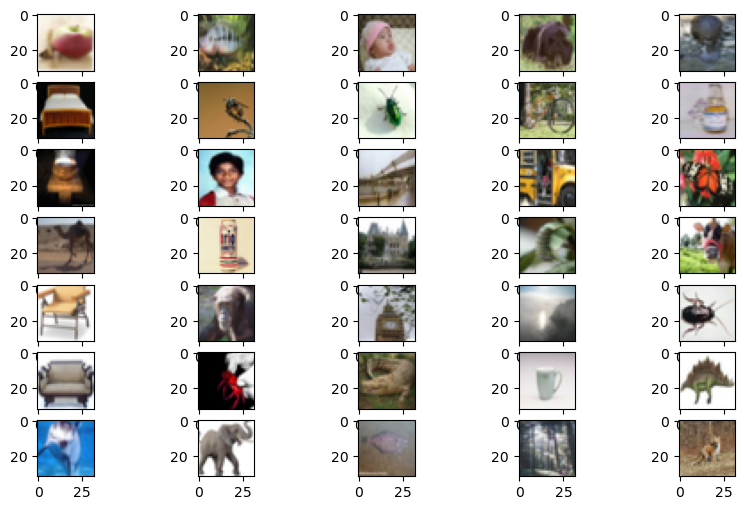

In [57]:
fig = plt.figure(figsize=(10,6))
num_classes=35
for i in range(num_classes):
    ax=fig.add_subplot(7,5,1+i)
    img=next(img for img, label in CIFAR100 if label==i)
    plt.imshow(img)
plt.show()

In [19]:
label1

6